In [ ]:
import pandas as pd 
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from google.colab import files
from google.colab import drive
import glob
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os

In [ ]:
drive.mount('/content/drive')
uploaded = files.upload()
dataframe = pd.read_csv('benign-and-malignant-images-labels-final.csv')
directory = '/content/drive/MyDrive/ML Project/Retinoblastoma-Project (current)/Data (current)/Benign-and-Malignant-Images'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving benign-and-malignant-images-labels-final.csv to benign-and-malignant-images-labels-final (3).csv


In [ ]:
image_list = []
for i in range(1, 282):
  filename = directory + "/" + str(i) + ".jpg"
  image = load_img(filename, target_size = (224, 224))
  image_list.append(np.array(image))

In [ ]:
for i in range(281): 
    if dataframe['benign_malignant'][i] == "malignant":
        dataframe['benign_malignant'][i] = 1
    elif dataframe['benign_malignant'][i] == "benign":
        dataframe['benign_malignant'][i] = 0
    else:
        dataframe['benign_malignant'][i] = -1

<ipython-input-16-1b4dba39b1f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 1
<ipython-input-16-1b4dba39b1f7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['benign_malignant'][i] = 0


In [ ]:
dataframe['images'] = image_list

In [ ]:
dataframeShuffled = shuffle(dataframe)

In [ ]:
train_ds, test_ds, train_labels, test_labels = train_test_split(dataframeShuffled['images'].tolist(), dataframeShuffled['benign_malignant'], test_size =  0.33, random_state = 1) 
train_labels_processed = to_categorical(train_labels, num_classes=5)
test_labels_processed = to_categorical(test_labels, num_classes=5)

In [ ]:
train_ds = tf.image.resize(train_ds, (224, 224))
test_ds = tf.image.resize(test_ds, (224, 224))

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False

train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

results = model.fit(train_ds, train_labels_processed, epochs=50, validation_split=0.4, batch_size=16, callbacks=[es]) 

Epoch 1/50
7/7 [==============================] - 155s 24s/step - loss: 1.2097 - accuracy: 0.8214 - val_loss: 0.0097 - val_accuracy: 0.9868
Epoch 2/50
7/7 [==============================] - 152s 24s/step - loss: 0.2973 - accuracy: 0.9821 - val_loss: 0.0968 - val_accuracy: 0.9868
Epoch 3/50
7/7 [==============================] - 153s 24s/step - loss: 4.2765e-05 - accuracy: 1.0000 - val_loss: 0.5024 - val_accuracy: 0.9868
Epoch 4/50
7/7 [==============================] - 152s 24s/step - loss: 2.0493e-05 - accuracy: 1.0000 - val_loss: 0.7338 - val_accuracy: 0.9737
Epoch 5/50
7/7 [==============================] - 152s 24s/step - loss: 7.4506e-09 - accuracy: 1.0000 - val_loss: 0.7802 - val_accuracy: 0.9737
Epoch 6/50
7/7 [==============================] - 157s 24s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.8108 - val_accuracy: 0.9737


In [ ]:
from sklearn.metrics import precision_score, precision_recall_fscore_support

In [ ]:
precision_score(train_ds, test_ds)

Text(0.5, 1.0, 'Loss')

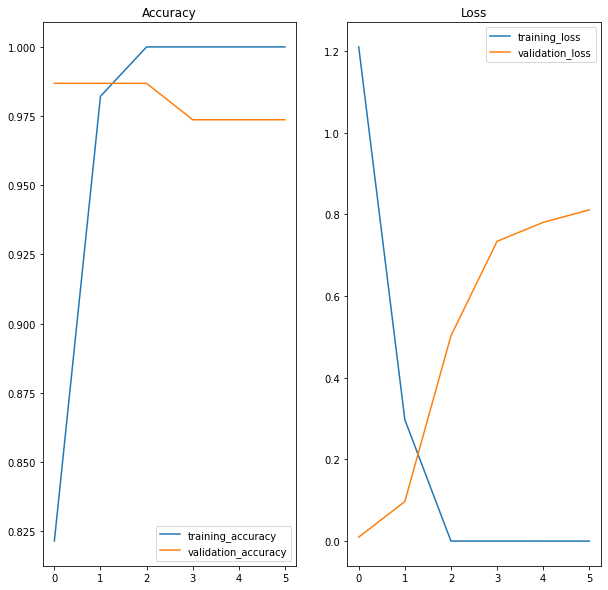

In [ ]:
accuracy = results.history['accuracy']
validation_accuracy = results.history['val_accuracy']
loss = results.history['loss']
validation_loss = results.history['val_loss']
epoch_number = range(6) # Changes depending on how many epochs were run before the early stop.

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(epoch_number, accuracy, label = 'training_accuracy')
plt.plot(epoch_number, validation_accuracy, label = 'validation_accuracy')
plt.legend(loc = 'lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epoch_number, loss, label = 'training_loss')
plt.plot(epoch_number, validation_loss, label = 'validation_loss')
plt.legend(loc = 'upper right')
plt.title('Loss')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
k_folds = KFold(n_splits = 5)

scores = cross_val_score(model, train_ds, train_labels, cv = k_folds, scoring = 'accuracy')

In [ ]:
cross_val_score(model, train_ds, train_labels, cv = 3, scoring = "accuracy")

In [ ]:
test = image_list[20] # 1-140 m, 141-281 b
test.shape
test = np.array(test)
test = tf.image.resize(test, (224, 224))
test = tf.expand_dims(test, 0)
predict = model.predict(test)
score = tf.nn.softmax(predict[0])
english = np.argmax(score)
percentage = np.max(score) * 100

1/1 [==============================] - 1s 1s/step


In [ ]:
if (english == 1):
  print("malignant, and with the highest probability of: ", percentage, "%. The actual label is (1 = malignant, 0 = benign): " + str(dataframe['benign_malignant'][20]))
if (english == 0):
  print("benign, and with highest probability of: ", percentage, "%. The actual label is (1 = malignant, 0 = benign): " + str(dataframe['benign_malignant'][20]))

malignant, and with the highest probability of:  40.460970997810364 %. The actual label is (1 = malignant, 0 = benign): 1


In [ ]:
test = image_list[200]
test.shape
test = np.array(test)
test = tf.image.resize(test, (224, 224))
test = tf.expand_dims(test, 0)
predict = model.predict(test)
score = tf.nn.softmax(predict[0])
english = np.argmax(score)
percentage = np.max(score) * 100

1/1 [==============================] - 1s 880ms/step


In [ ]:
if (english == 1):
  print("malignant, and with the highest probability of: ", percentage, "%. The actual label is (1 = malignant, 0 = benign): " + str(dataframe['benign_malignant'][200]))
if (english == 0):
  print("benign, and with highest probability of: ", percentage, "%. The actual label is (1 = malignant, 0 = benign): " + str(dataframe['benign_malignant'][200]))

benign, and with highest probability of:  40.460753440856934 %. The actual label is (1 = malignant, 0 = benign): 0


In [ ]:
preds = model.evaluate(test_ds, test_labels_processed)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 [==============================] - 66s 21s/step - loss: 0.0221 - accuracy: 0.9892
Loss = 0.022147003561258316
Test Accuracy = 0.9892473220825195


In [ ]:
preds = model.predict(test_ds)

3/3 [==============================] - 57s 19s/step


In [ ]:
preds_soft = tf.nn.softmax(preds[0])
# preds_soft
# len(test_ds)

In [ ]:
preds_max = np.argmax(preds_soft)
preds_max

1

In [ ]:
predictions = []
for i in range(0, 93):
  predictions.append(np.argmax(tf.nn.softmax(preds[i])))

In [ ]:
# len(predictions)
test_labels.shape

(93,)

In [ ]:
len(predictions)

93

In [ ]:
np.array(predictions).astype('float32')

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 1., 0., 0.], dtype=float32)

In [ ]:
np.array(test_labels).astype('float32')

array([0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 1.], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(df.actual_label.values, df.predicted_RF.values)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchmetrics import JaccardIndex
from torchmetrics.functional import dice
import torch

In [ ]:
jaccard = JaccardIndex(task="multiclass", num_classes=2)
# dice = Dice(num_classes = 2)

In [ ]:
# from torchmetrics.functional import dice
# preds = torch.tensor([2, 0, 2, 1])
# target = torch.tensor([1, 1, 2, 0])
# dice(preds, target, average='micro')

In [ ]:
print("This is the Jaccard index: " + str(jaccard(torch.from_numpy(np.array(predictions)), torch.from_numpy(np.array(test_labels).astype('float32')))))
print("This is the Dice Similarity Coefficient: " + str(dice(torch.from_numpy(np.array(test_labels).astype('float32')), torch.from_numpy(np.array(predictions)), average = 'micro')))

This is the Jaccard index: tensor(0.9787)
This is the Dice Similarity Coefficient: tensor(0.9890)


In [ ]:
from sklearn.metrics import confusion_matrix
x = confusion_matrix(torch.from_numpy(np.array(test_labels).astype('float32')), np.array(predictions))
x

array([[47,  0],
       [ 1, 45]])

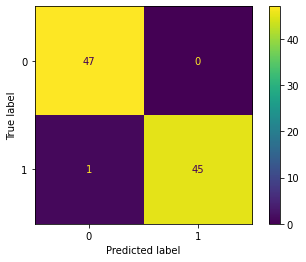

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# from sklearn.svm import SVC
# X, y = make_classification(random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    random_state=0)
# clf = SVC(random_state=0)
# clf.fit(X_train, y_train)

# predictions = clf.predict(X_test)
# cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=x,
                              display_labels={0, 1})
disp.plot()

plt.show()